In [2]:
import jieba 
import pandas as pd
import collections
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from operator import itemgetter
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

读入SEM数据。第一列是关键词文本，第二列是对数变化后的平均展现量

In [3]:
SEM=pd.read_csv("SEM.csv")
SEM

,kw,logImp
0,1.5折机票,2.302585
1,10.1机票,1.609438
2,10.1机票查询,1.791759
3,10.1特价机票,1.568616
4,10月份特价机票,2.036882
...,...,...
4836,最低折扣机票,3.786373
4837,最低折扣机票查询,2.826656
4838,最好的机票网站,1.845827
4839,最好的机票预订网站,1.386294


利用jieba分词：
（1）wdtrain是一个长度为样本量的list，每一个元素又是一个list，其中每一个元素是分词后的最基本的词。
（2）wdlist是一个长度不确定的list，它是把所有的样本的分词结果全部都串在一起了

In [4]:
wdtrain=[];wdlist=[]
for kw in SEM.kw:
    wd=jieba.lcut(kw)
    wdtrain.append(wd)
    wdlist=wdlist+wd

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.672 seconds.
Prefix dict has been built successfully.


通过对wdlist的各种操作，找到每个【词根】出现的频率，并降序排列

In [5]:
tab=collections.Counter(wdlist)
df = pd.DataFrame.from_dict(tab,orient="index").reset_index()
df = df.rename(columns={'index':'kw', 0:'count'})
df = df.sort_values(by='count',ascending=False)

生成一个字典，将词根变为整数，从0开始到ncov结束

In [6]:
ncov=len(df.kw)
topkw=list(df.kw)
mydict=dict.fromkeys(topkw)  #会造一个value是空的字典
for i in range(ncov):
    mydict[topkw[i]]=i
mydict 

{'机票': 0,
 '飞机票': 1,
 '特价机票': 2,
 '查询': 3,
 '预订': 4,
 '便宜': 5,
 '-': 6,
 '打折': 7,
 '特价': 8,
 '到': 9,
 '深圳': 10,
 '北京': 11,
 '航班': 12,
 '广州': 13,
 '的': 14,
 '上海': 15,
 '网站': 16,
 '预定': 17,
 '网': 18,
 '订': 19,
 '飞机': 20,
 '网上': 21,
 '订机票': 22,
 '机票价格': 23,
 '三亚': 24,
 '价格': 25,
 '订票': 26,
 '买': 27,
 '十一': 28,
 '五一': 29,
 '折扣': 30,
 '南京': 31,
 '厦门': 32,
 '订购': 33,
 '重庆': 34,
 '武汉': 35,
 '天津': 36,
 '海口': 37,
 '长沙': 38,
 '昆明': 39,
 '去': 40,
 '最': 41,
 '哈尔滨': 42,
 '多少': 43,
 '定': 44,
 '大连': 45,
 '乌鲁木齐': 46,
 '钱': 47,
 '哪个': 48,
 '杭州': 49,
 '哪里': 50,
 '旅游': 51,
 '郑州': 52,
 '长春': 53,
 '官网': 54,
 '南宁': 55,
 '济南': 56,
 '电话': 57,
 '呼和浩特': 58,
 '机票网': 59,
 '成都': 60,
 '西安': 61,
 '南昌': 62,
 '票价': 63,
 '时刻表': 64,
 '珠海': 65,
 '烟台': 66,
 '春节': 67,
 '低价': 68,
 '太原': 69,
 '端午节': 70,
 '北京机票': 71,
 '自助游': 72,
 '什么': 73,
 '西双版纳': 74,
 '沈阳': 75,
 '廉价': 76,
 '往返机票': 77,
 '哪儿': 78,
 '青岛': 79,
 '攻略': 80,
 '好': 81,
 '怎么': 82,
 '成都机票': 83,
 '放假': 84,
 '携程网': 85,
 '优惠机票': 86,
 '2013': 87,
 '西安机票': 88,
 '如何': 89,
 

生成一个X的0-1矩阵。如果一个关键词包含相应词根，那么对应的X元素取值为1，否则为0

In [7]:
ss=len(SEM.kw)
ncov=len(mydict)
X=np.zeros([ss,ncov+1])
for i in range(ss):
    columnID=itemgetter(*wdtrain[i])(mydict)
    X[i,columnID]=1
    X[i,ncov]=len(SEM.kw[i])    

In [8]:
X

array([[1., 0., 0., ..., 0., 0., 6.],
       [1., 0., 0., ..., 0., 0., 6.],
       [1., 0., 0., ..., 0., 0., 8.],
       ...,
       [1., 0., 0., ..., 0., 0., 7.],
       [1., 0., 0., ..., 0., 0., 9.],
       [0., 0., 0., ..., 0., 0., 5.]])

In [9]:
Y=np.array(SEM.logImp)
Y=(Y-np.mean(Y))/np.std(Y)
niter=1000
R21=np.zeros(niter)
regmodel = LinearRegression()
for i in range(niter):
    X0,X1,Y0,Y1= train_test_split(X,Y,test_size=0.5,random_state=i)
    regmodel.fit(X0,Y0)
    Yhat=regmodel.predict(X1)
    R21[i]=100.0*(1-np.median((Yhat-Y1)**2))
np.round(np.median(R21),2)

72.77

接下来做一个word2vec模型，假设laten空间的维数为100

In [10]:
DIM=100
wvmodel = Word2Vec(wdtrain, size=DIM, min_count=1)
Z=np.zeros([ss,DIM])
for i in range(ss):
    vec=wvmodel[wdtrain[i]]
    Z[i,:]=np.mean(vec,0)

把word2vect学习出来的空间坐标的平均值作为一个新的解释性变量Z与前面的X整合，形成新的矩阵XZ，然后做Y对XZ的回归分析，并检测外样本预测精度

In [11]:
XZ=np.hstack((X,Z))
niter=1000
R22=np.zeros(niter)
regmodel = LinearRegression()
for i in range(niter):
    XZ0,XZ1,Y0,Y1= train_test_split(XZ,Y,test_size=0.5,random_state=i)
    regmodel.fit(XZ0,Y0)
    Yhat=regmodel.predict(XZ1)
    R22[i]=100.0*(1-np.median((Yhat-Y1)**2))
np.round(np.median(R22),2)

75.24

对两个不同的模型，多次随机模型的重复结果，做箱线图对比如下。结果令人振奋！

{'whiskers': [<matplotlib.lines.Line2D at 0x7f11b8683350>,
 'caps': [<matplotlib.lines.Line2D at 0x7f11b8683910>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f11b86f2650>,
 'medians': [<matplotlib.lines.Line2D at 0x7f11b8690350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f11b8690890>,
 'means': []}

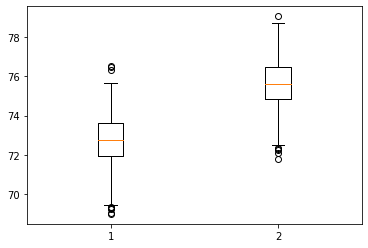

In [10]:
plt.boxplot((R21,R22))